# Time Frequency Representations

In [36]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

data_dir = "./data/digits_epochs/"
file = data_dir + "freq_bands/all_data_all_epochs.pkl"
all_epochs = pickle.load(open(file, "rb")).pick(picks="meg", exclude="bads")
all_epochs = all_epochs.decimate(2)
info_epochs = all_epochs.info

## Calculate TFR

In [37]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 5
fmax = 60
freqs = np.arange(fmin, fmax + 1, 3)
n_cycles = freqs / 2  # different number of cycle per frequency

if os.path.exists(data_dir + "all_epochs_tfr.pkl"):
    with open(data_dir + "all_epochs_tfr.pkl", "rb") as f:
        power = pickle.load(f)
else:

    power = {}
    for idx, label in enumerate(labels):
        valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
        label_epochs = all_epochs[valid_epochs_mask]

        power[idx + 1] = mne.time_frequency.tfr_morlet(
            label_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=1,
            return_itc=False,
            decim=3,
        )


### Plot TFR on different states

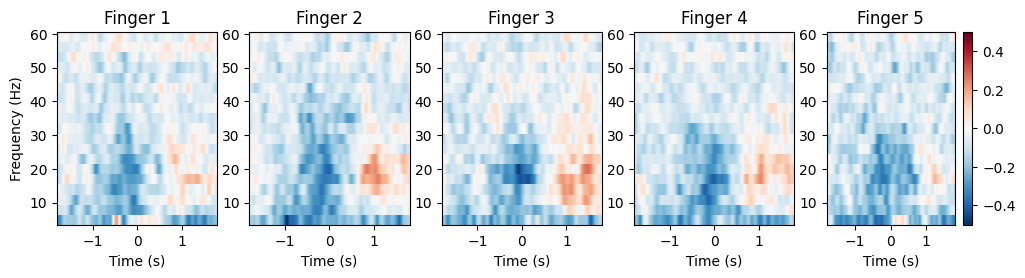

In [38]:
channel1 = "LQ[X]"
channel4 = "HI[X]"
channel5 = "FW[X]"
channel2 = "FY[Y]"
channel3 = "HQ[Z]"

center_channel = channel1
idx_channel = all_epochs.ch_names.index(center_channel)

conditions = [1, 2, 3, 4, 5]

# Create a figure with subplots
fig, axes = plt.subplots(
    1, len(conditions), figsize=(12, 2.5)
)  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]

    # Plot the 5 different digits in a subplot horziontally
    if i ==4:
        colorbar = True
    else:
        colorbar = False
    power[condition].plot(
        [idx_channel],
        baseline=(-2, -0.57),
        mode="logratio",
        tmin=-1.8,
        tmax=1.8,
        axes=ax,
        show=False,
        vmin=-0.5,
        vmax=0.5,
        colorbar=colorbar,
        verbose=False,
    )
    if i == 0:
        ax.set_ylabel("Frequency (Hz)")
    else:
        ax.set_ylabel("")
    ax.grid(False)
    ax.set_title("Finger " + str(i + 1))

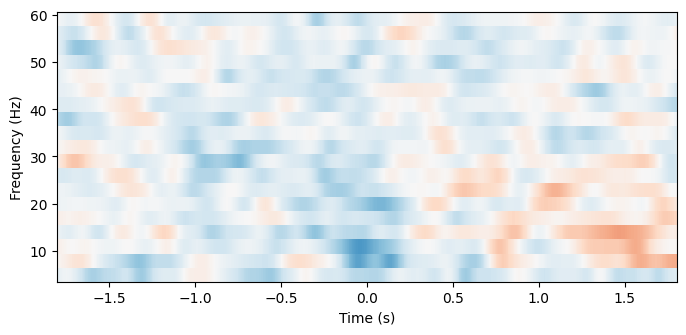

In [39]:
channel1 = "LQ[X]"
channel4 = "HI[X]"
channel5 = "FW[X]"
channel2 = "FY[Y]"
channel3 = "HQ[Z]"

center_channel = channel3
idx_channel = all_epochs.ch_names.index(center_channel)

# Create a figure with subplots
fig, ax = plt.subplots(
    1, 1, figsize=(8, 3.5)
)  # Adjust figsize as needed

power[3].plot(
    [idx_channel],
    baseline=(-2, -0.57),
    mode="logratio",
    tmin=-1.8,
    tmax=1.8,
    axes=ax,
    show=False,
    vmin=-0.5,
    vmax=0.5,
    colorbar=None,
    verbose=False,
)
# ax.set_xticks(np.arange(-0.5, 1.76, 0.25))
ax.set_ylabel("Frequency (Hz)")
ax.grid(False)
# Save figure in svg
plt.savefig("./pictures/tfr_3.svg")

### Creating figure of frequency importance

In [40]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 2
fmax = 45
freqs = np.arange(fmin, fmax + 1, 1)
n_cycles = freqs / 2  # different number of cycle per frequency

power_small_scale = {}
idx_channel = all_epochs.ch_names.index(center_channel)

for idx, label in enumerate(labels):
    valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
    label_epochs = all_epochs[valid_epochs_mask]

    power_small_scale[idx + 1] = mne.time_frequency.tfr_morlet(
        label_epochs,
        freqs=freqs,
        n_cycles=n_cycles,
        picks=idx_channel,
        n_jobs=5,
        return_itc=False,
        decim=3,
        verbose=False,
    )

### Rescaling power


In [41]:
from mne.baseline import rescale

power_scaled = []
integrated_power = []

for i in range(5):
    data = power_small_scale[i + 1].data[0]
    times = power_small_scale[i + 1].times
    baseline = (-2, -0.57)
    data = rescale(data, times, baseline, mode="logratio", verbose=False)
    if np.iscomplexobj(data):
        data = (data * data.conj()).real
    time_indices = np.where((times >= -1.75) & (times <= 1.75))[0]
    times = times[time_indices]
    power_scaled.append(data[:, time_indices])

    time_idx = np.where((times >= 0.75) & (times <= 1.75))[0]
    integrated_power.append(np.mean(power_scaled[i][:, time_idx], axis=1))

integrated_power = np.array(integrated_power)

power_scaled = np.array(power_scaled)
variance = np.var(power_scaled[:], axis=2)
mean = np.mean(power_scaled[:], axis=2)

### Figure of Synchronization Frequency Power

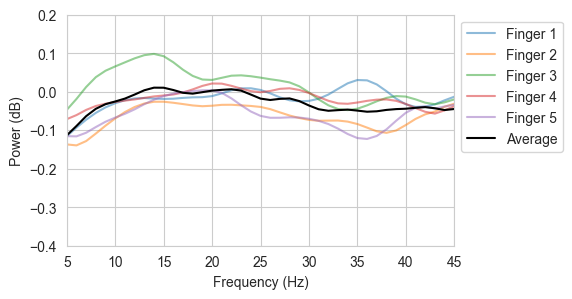

In [42]:
import seaborn as sns
import pandas as pd

data_list = []

sns.set_style("whitegrid")

# Create the line plot with confidence interval
plt.figure(figsize=(5, 3))

num = 0
ylim = (-0.4, 0.2)
xlim = (5, 45)

# Plot the lineplot of all digits
for power in integrated_power:
    # Do a low pass filter of the power np.array
    power = np.convolve(power, np.ones(5), "same") / 5
    df = pd.DataFrame({"Power":power})
    df["Frequency"] = freqs
    num += 1
    lineplot = sns.lineplot(
        data=df,
        x="Frequency",
        y="Power",
        label="Finger " + str(num),
        alpha= 0.5
    )
    lineplot.set_xlabel("Frequency (Hz)")
    lineplot.set_ylabel("Power (dB)")
    lineplot.set(xlim=xlim)
    lineplot.set(ylim=ylim)
average_df = df
average_df["Power"] = integrated_power.mean(axis=0)
lineplot = sns.lineplot(
    data=average_df,
    x="Frequency",
    y="Power",
    label="Average",
    alpha=1,
    color="black",
)

# Set legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(
    "./pictures/sfp_" + center_channel + ".svg", format="svg", bbox_inches="tight"
)
plt.show()

### Locating the sensors chosen

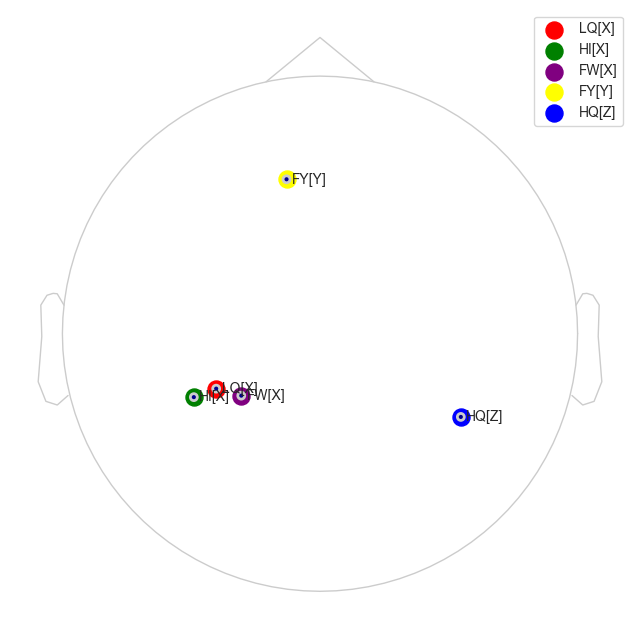

In [57]:
from mne.viz.topomap import _find_topomap_coords

channel1 = "LQ[X]"
channel2 = "FY[Y]"
channel3 = "HQ[Z]"
channel4 = "HI[X]"
channel5 = "FW[X]"

sphere = 0.12

pos1 = _find_topomap_coords(all_epochs.info, picks=channel1, sphere=.12)[0]
pos2 = _find_topomap_coords(all_epochs.info, picks=channel2, sphere=.12)[0]
pos3 = _find_topomap_coords(all_epochs.info, picks=channel3, sphere=.12)[0]
pos4 = _find_topomap_coords(all_epochs.info, picks=channel4, sphere=.12)[0]
pos5 = _find_topomap_coords(all_epochs.info, picks=channel5, sphere=.21)[0]

# Highlight with dots around the sensors
fig, axes = plt.subplots(1,figsize=(8,8))

axes.scatter(*pos1, color="red", s=150, label=channel1)
axes.scatter(*pos4, color="green", s=150, label=channel4)
axes.scatter(*pos5, color="purple", s=150, label=channel5)
axes.scatter(*pos2, color="yellow", s=150, label=channel2)
axes.scatter(*pos3, color="blue", s=150, label=channel3)
axes.legend()

# Take from all_epochs the channels that are not [X] or in channel 1, 2, 3, 4, 5
# channel_names = [ch for ch in all_epochs.ch_names if "[X]" in ch and ch in [channel1, channel2, channel3, channel4, channel5]]
channel_names = [
    ch
    for ch in all_epochs.ch_names
    if ch in [channel1, channel2, channel3, channel4, channel5]
]

plot_epochs = all_epochs.copy().pick(picks=channel_names)
fig = plot_epochs.plot_sensors(show_names=True, sphere=sphere, axes=axes)

fig.savefig("./pictures/sensors_map.svg", format="svg", bbox_inches="tight")